# 1.Regularized Linear Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.io import loadmat

In [2]:
data = loadmat('ex5data1.mat')
X = data['X']
y = data['y']
Xval = data['Xval']
yval = data['yval']
Xtest = data['Xtest']
ytest = data['ytest']

In [3]:
X.shape, y.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape

((12, 1), (12, 1), (21, 1), (21, 1), (21, 1), (21, 1))

## 1.1训练数据可视化

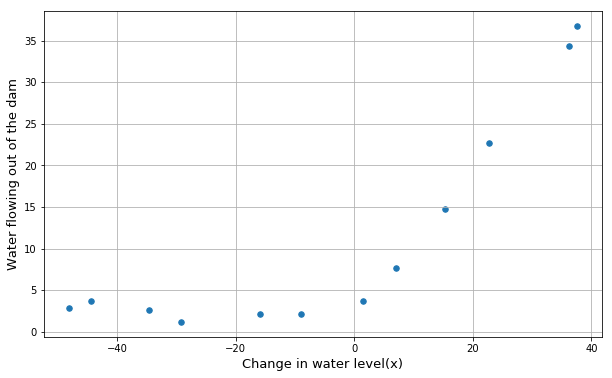

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(X, y, s=30)
ax.grid(True)
plt.xlabel('Change in water level(x)', size=13)
plt.ylabel('Water flowing out of the dam', size=13)
plt.show()

**给X增加bias项, 全为1**

In [5]:
X = np.insert(X.reshape(len(X), 1), 0, np.ones(len(X)), axis=1)
Xval =  np.insert(Xval.reshape(len(Xval), 1), 0, np.ones(len(Xval)), axis=1)
Xtest =  np.insert(Xtest.reshape(len(Xtest), 1), 0, np.ones(len(Xtest)), axis=1)

In [6]:
X.shape, Xval.shape, Xtest.shape

((12, 2), (21, 2), (21, 2))

## 1.2 Regularized linear regression cost function

In [7]:
def cost(theta, X, y):
    m = y.shape[0]
    theta = theta.reshape(theta.shape[0], 1)
    h = np.dot(X, theta)
    J = 1. / (2 * m) * np.sum(np.power(h - y, 2))
    
    return J

In [8]:
theta = np.ones(X.shape[1])
cost(theta, X, y)

303.9515255535976

In [9]:
def regularized_cost(theta, X, y, labmda=1.0):
    m = y.shape[0]
    
    return cost(theta, X, y) + labmda / (2 * m) * np.sum(np.power(theta[1:], 2)) #注意theta0没有罚项

### 结果与文档一致

In [10]:
regularized_cost(theta, X, y)

303.9931922202643

## 1.3 Regularized linear regression gradient

In [11]:
def regularized_gradient(theta, X, y, labmda=1.0):
    m = y.shape[0]
    theta = theta.reshape(theta.shape[0], 1)
    h = np.dot(X, theta)
    update = 1. / m * np.dot(X.T, (h - y))
    reg = labmda / m * theta
    reg[0] = 0
    
    return (update + reg).squeeze()

### 结果与文档一致

In [12]:
regularized_gradient(theta, X, y)

array([-15.30301567, 598.25074417])

## 1.4 Fitting linear regression，由文档可知此时$\lambda$ = 0

In [13]:
def linear_regression(X, y, labmda):
    
    theta = np.ones(X.shape[1])
    
    #下面两个优化方式得到的结果是一样的, 但是结果和大神的结果有些出入，有些细微的区别，目前还没有发现是哪里不一样导致的
#     outcome = opt.fmin_tnc(func=regularized_cost, x0=theta, fprime=regularized_gradient, args=(X, y, labmda))
    outcome = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, labmda),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'disp': True})
    
#     print(outcome)
#   return outcome[0]
    return outcome.x 

[13.08790394  0.36777923]


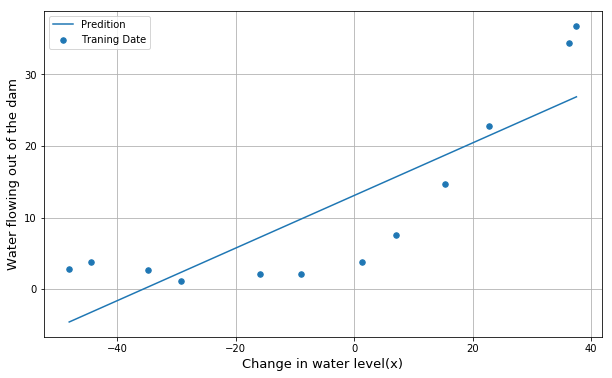

In [14]:
theta = linear_regression(X, y, 0)
print(theta)

x_plot = np.linspace(X.min(), X.max(), 100)
bias = theta[0]
slope = theta[1]
y_plot = slope * x_plot + bias

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(X[:, 1], y, s=30, label='Traning Date')
ax.plot(x_plot, y_plot, label='Predition')
ax.grid(True)
plt.xlabel('Change in water level(x)', size=13)
plt.ylabel('Water flowing out of the dam', size=13)
plt.legend(loc=2)
plt.show()

# 2.Bias-variance

In [15]:
training_cost, cv_cost = [], []

In [16]:
m = X.shape[0]
for i in range(1, m+1):
    params = linear_regression(X[:i, :], y[:i], 0)
    
    train = regularized_cost(params, X[:i, :], y[:i], 0)     #训练集计算cost只带入进行训练了的样本, 并且误差不包括正则项
    cv = regularized_cost(params, Xval, yval, 0)             #验证集计算cost与训练集不同，而是全部带入
    
    training_cost.append(train)
    cv_cost.append(cv)

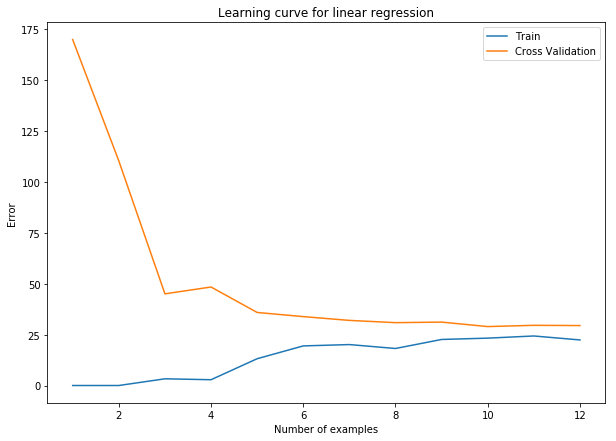

In [17]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(1, m+1), training_cost, label='Train')
plt.plot(np.arange(1, m+1), cv_cost, label='Cross Validation')
plt.xlabel('Number of examples')
plt.ylabel('Error')
plt.legend()
plt.title('Learning curve for linear regression')
plt.show()

# 3.Ploynomial regression

## 3.1 创建多项特征，涉及归一化

In [18]:
#重新加载一次
data = loadmat('ex5data1.mat')
X = data['X']
y = data['y']
Xval = data['Xval']
yval = data['yval']
Xtest = data['Xtest']
ytest = data['ytest']
X.shape, y.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape

((12, 1), (12, 1), (21, 1), (21, 1), (21, 1), (21, 1))

In [19]:
def ploy_features(X, power):
    data = {"f" + str(i):np.power(X[:, 0], i) for i in range(1, power+1)}
    df = pd.DataFrame(data)
    
    return df

def normalize(X):               #归一化使用DataFrame的数据类型比较方便
    return (X - X.mean()) / X.std()

def prepare_data(X, power):
    X = np.array(normalize(ploy_features(X, power)))
    return np.insert(X, 0, values=np.ones(X.shape[0]), axis=1)

In [20]:
#只涉及到计算损失，而不会做预测所以无需保留均值和方差
X_ploy = prepare_data(X, 8)
Xval_ploy = prepare_data(Xval, 8)
Xtest_poly = prepare_data(Xtest, 8)
X_ploy[:3, :]

array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01, -5.08481165e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01, -4.48912493e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01, -1.70352114e-01]])

In [21]:
def plot_learning_curve(X, y, Xval, yval, labmda):
    training_cost, cv_cost = [], []
    m = X.shape[0]
    
    for i in range(1, m+1):
        #这里X的切片与上面代码不同，这里X有9列，如果还用上文的方式会报错
        params = linear_regression(X[:i, :], y[:i], labmda)

        train = regularized_cost(params, X[:i, :], y[:i], 0)     #训练集计算cost只带入进行训练了的样本, 并且误差不包括正则项
        cv = regularized_cost(params, Xval, yval, 0)             #验证集计算cost与训练集不同，而是全部带入

        training_cost.append(train)
        cv_cost.append(cv)
    
    plt.figure(figsize=(10, 7))
    plt.plot(np.arange(1, m+1), training_cost, label='Train')
    plt.plot(np.arange(1, m+1), cv_cost, label='Cross Validation')
    plt.xlabel('Number of examples')
    plt.ylabel('Error')
    plt.legend()
    plt.title('Learning curve for linear regression')
    plt.show()

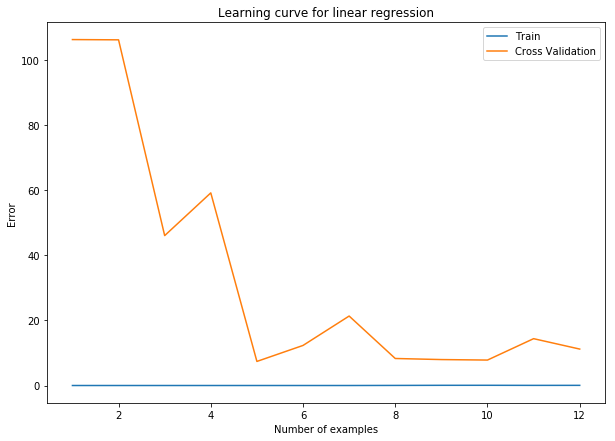

In [22]:
plot_learning_curve(X_ploy, y, Xval_ploy, yval, 0) #无正则化,明显对训练集过拟合了，但是可以看出随着训练集的增加方差在减小

# $\lambda = 1$

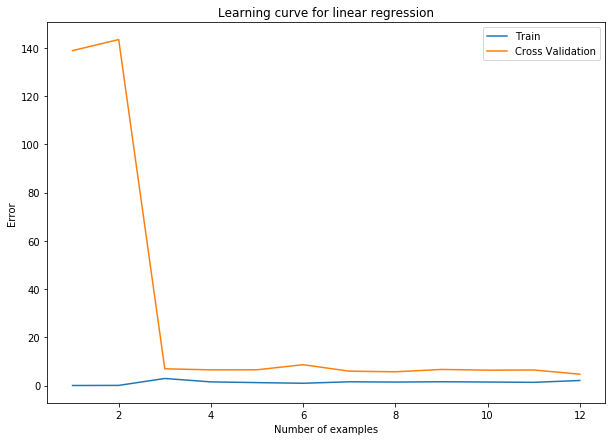

In [23]:
plot_learning_curve(X_ploy, y, Xval_ploy, yval, 1.0)

# $\lambda = 100$

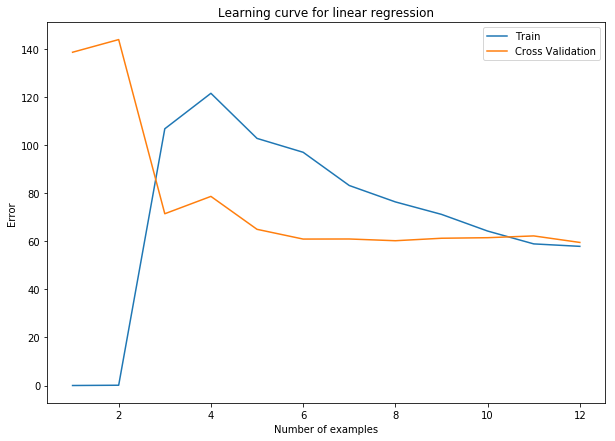

In [24]:
plot_learning_curve(X_ploy, y, Xval_ploy, yval, 100.0) 

## 3.2 Adjusting the regularization parameter

In [25]:
labmda = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

**最开始我在计算误差时加入了正则化，后来从文档中发现不需要加入正则化，除了最后3.4以外**

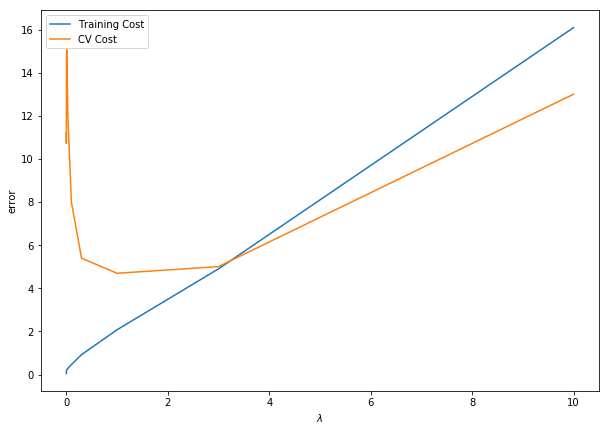

In [26]:
training_cost, cv_cost = [], []
for l in labmda:
    params = linear_regression(X_ploy, y, l)
#     print(params)
    train = regularized_cost(params, X_ploy, y, 0)
    cv = regularized_cost(params, Xval_ploy, yval, 0)   #误差不包括正则项
    
    training_cost.append(train)
    cv_cost.append(cv)
    
plt.figure(figsize=(10, 7))
plt.plot(labmda, training_cost, label='Training Cost')
plt.plot(labmda, cv_cost, label='CV Cost')
plt.xlabel(r'$\lambda$')
plt.ylabel('error')
plt.legend()
plt.show()

## 3.3 Selecting $\lambda$ using a cross validation set

In [27]:
labmda[np.argmin(cv_cost)]

1

## 3.4  Computing test set error

In [28]:
for l in labmda:
    params = linear_regression(X_ploy, y, l)
    print(r"l = {} test cost is ".format(l)+str(regularized_cost(params, Xtest_poly, ytest, 0))) 

l = 0 test cost is 10.047024076473404
l = 0.001 test cost is 11.083367066268188
l = 0.003 test cost is 11.305148535674872
l = 0.01 test cost is 10.972118790611576
l = 0.03 test cost is 10.243881381573468
l = 0.1 test cost is 9.194420737178628
l = 0.3 test cost is 8.582380442490413
l = 1 test cost is 10.43312841602354
l = 3 test cost is 17.91041201415129
l = 10 test cost is 37.58935776594602
